# 0.0 Imports

### 0.1. Helper functions

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
from IPython.display import Image
from scipy import stats as ss

#função corrigida
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

### 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv(r'C:\Users\laais\OneDrive\Área de Trabalho\Programação\Curso Ds em Produção\rossmann-store-sales\train.csv', low_memory=False)

df_store_raw = pd.read_csv(r'C:\Users\laais\OneDrive\Área de Trabalho\Programação\Curso Ds em Produção\rossmann-store-sales\store.csv', low_memory=False)

In [2]:
df_sales_raw = pd.read_csv(r'C:\Users\laism\Downloads\rossmann-store-sales\train.csv', low_memory=False)

#df_store_raw = pd.read_csv(r'C:\Users\laism\Downloads\rossmann-store-sales\store.csv', low_memory=False)

In [6]:
df_sales_raw.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [50]:
#merge dos dois dfs
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 - PASSO 1 - Descrição dos dados

In [51]:
#copia dos dados originais para ficar tipo como um backup
df1 = df_raw.copy()

### 1.1. Rename columns

In [52]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [53]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#função que deixa tudo minusculo e separado por _
snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

### 1.2. Data dimensions

In [54]:
print('N° de linhas: {}'.format(df1.shape[0]))
print('N° de colunas {}'.format(df1.shape[1]))

N° de linhas: 1017209
N° de colunas 18



### 1.3. Data types

In [55]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [56]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [57]:
#quantidade de células vazias
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Preenchendo o NA

In [58]:
#CompetitionDistance - distance in meters to the nearest competitor store
#vou assumir que se o valor é mt maior que a distância máxima que tem um competidor proximo então é a msm coisa que dizer que não tem um competidor proxim

max_value = df1['competition_distance'].max()
#isnan avalia se é NA
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

In [59]:
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#vou assumir que é vazio pqe não tem um competidor mais proximo ou tem um competidor proximo mas não temos info de quando abriu
#vou substituir pelo mês da data da venda

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [60]:
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [61]:
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
#dict para trocar o num pelo nome do mês
month_map = {1: 'Jan',
             2: 'Fev',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sept',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

#susbtitui o N/A por zero
df1['promo_interval'].fillna(0, inplace=True)

#extraindo o mês da data e aplicando o dicionario para fazer a tradução
df1['month_map'] = df1['date'].dt.month.map(month_map)

#avaliação se o month_map está dentro do intervalo para ver se a loja está na promoção (1) ou não (0)
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [62]:
#quantidade de células vazias
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Change Types

In [63]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [64]:
#passando para inteiro
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Estatísticas descritivas

- Métricas de tendência central: média e mediana
- Métricas de dispersão: desvio padrão, max, min e range, skew e kurtosis

In [65]:
#separando os atributos numéricos
num_attributes = df1.select_dtypes( include = ['int64','int32','float64'])

#separando os atributos categóricos
cat_attributes = df1.select_dtypes( exclude = ['int64','int32','float64','datetime64[ns]'])

In [66]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7.1 Atributos numéricos

In [67]:
#media e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#desvio padrão, max, min e range, skew e kurtosis
std = pd.DataFrame(num_attributes.apply( np.std )).T
min_ = pd.DataFrame(num_attributes.apply( min )).T
max_ = pd.DataFrame(num_attributes.apply( max )).T
range_ = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
skew = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
kurtosis = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenando
m = pd.concat([min_, max_, range_, ct1, ct2, std, skew, kurtosis]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [68]:
sns.set(rc={'figure.figsize':(10,5)})

C:\Users\laism\AppData\Local\Temp\ipykernel_22848\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

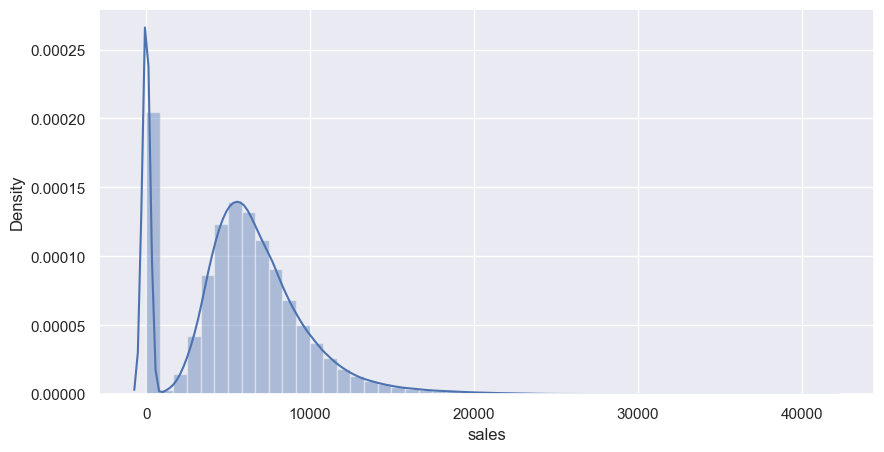

In [69]:
sns.distplot(df1['sales'])

C:\Users\laism\AppData\Local\Temp\ipykernel_22848\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

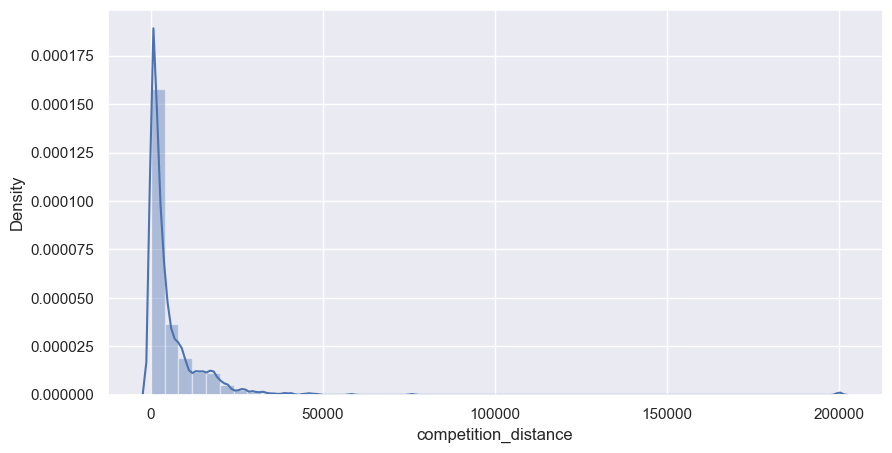

In [70]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Atributos categóricos

In [71]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

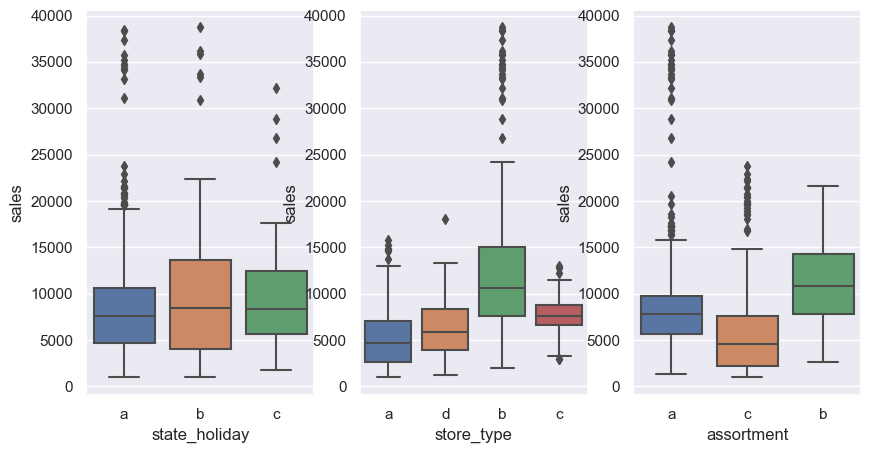

In [72]:
#filtrando os dias não tem feriado e que tem venda maior q 0
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)        

# 2.0 - PASSO 2 - Feature Engineering

In [73]:
df2 = df1.copy()

## 2.1 Mapa Mental

In [74]:
#Image('mapa.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menor.

**5.** Lojas com maior maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais proximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que tem entram mais nos feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.


## 2.3 Lista final de hipóteses

(Sugestão de priorização de hipóteses: escolha hipóteses em que você já tem o dado disponível naquele momento)

**1**. Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

Feature Engineering refere-se ao processo de usar o conhecimento do domínio para selecionar e transformar as variáveis mais relevantes dos dados brutos

In [75]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [76]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_wear'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#cometition since
#datetime.datetime() é uma função que monta uma data apartir de valores
df2['competion_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1), axis=1)
df2['competion_time_month'] = ((df2['date'] - df2['competion_since'])/30 ).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

#assortment
#Assortment - describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
#StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\laism\AppData\Local\Temp\ipykernel_22848\291384789.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_wear'] = df2['date'].dt.weekofyear


In [77]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - PASSO 3 - Filtragem de variáveis

In [78]:
df3 = df2.copy()

In [79]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_wear,year_week,competion_since,competion_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [80]:
#só vou usar as vendas em que open é diferente de zero
#sellers tem que ser maior que zero

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [81]:
#baseado no contexto, não vamos ter a coluna customers no momento da previsão pqe não tem como prever quantos clientes vai ter no dia
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - PASSO 4 - Análise Exploratória dos Dados

In [82]:
df4 = df3.copy()

In [83]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_wear,year_week,competion_since,competion_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Análise Univariada

### 4.1.1 Response Variable

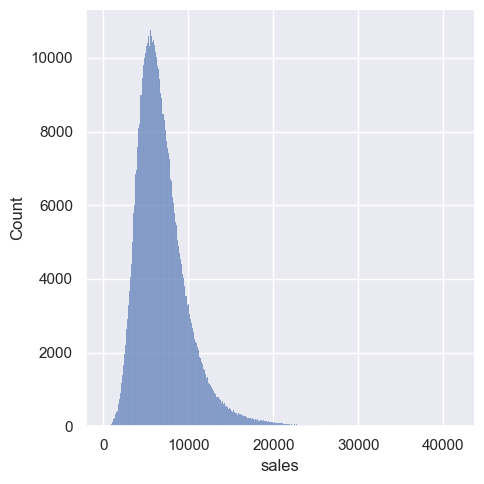

In [84]:
#a variavel resposta é a sales
sns.displot(df4['sales'])

É importante avaliar a variável resposta porque a maioria dos algoritmos de Machine Learning são criados baseados em algumas premissas, ou seja, baseado em alguns comportamentos do ambiente. 

Uma dessas premissas é que os dados sejam independentes e que sigam uma distribuição normal. Quanto mais normal for a variável resposta, melhor seu algoritmo vai performar. 

Existem algumas técnicas para transformar a sua variável resposta mais próxima possível na distruição normal. 

### 4.1.2 Numere Variable

In [85]:
num_attributes.head().T

,0,1,2,3,4
store,1.0,2.0,3.0,4.0,5.0
day_of_week,5.0,5.0,5.0,5.0,5.0
sales,5263.0,6064.0,8314.0,13995.0,4822.0
customers,555.0,625.0,821.0,1498.0,559.0
open,1.0,1.0,1.0,1.0,1.0
promo,1.0,1.0,1.0,1.0,1.0
school_holiday,1.0,1.0,1.0,1.0,1.0
competition_distance,1270.0,570.0,14130.0,620.0,29910.0
competition_open_since_month,9.0,11.0,12.0,9.0,4.0
competition_open_since_year,2008.0,2007.0,2006.0,2009.0,2015.0


In [86]:
df1['customers'].max()

7388

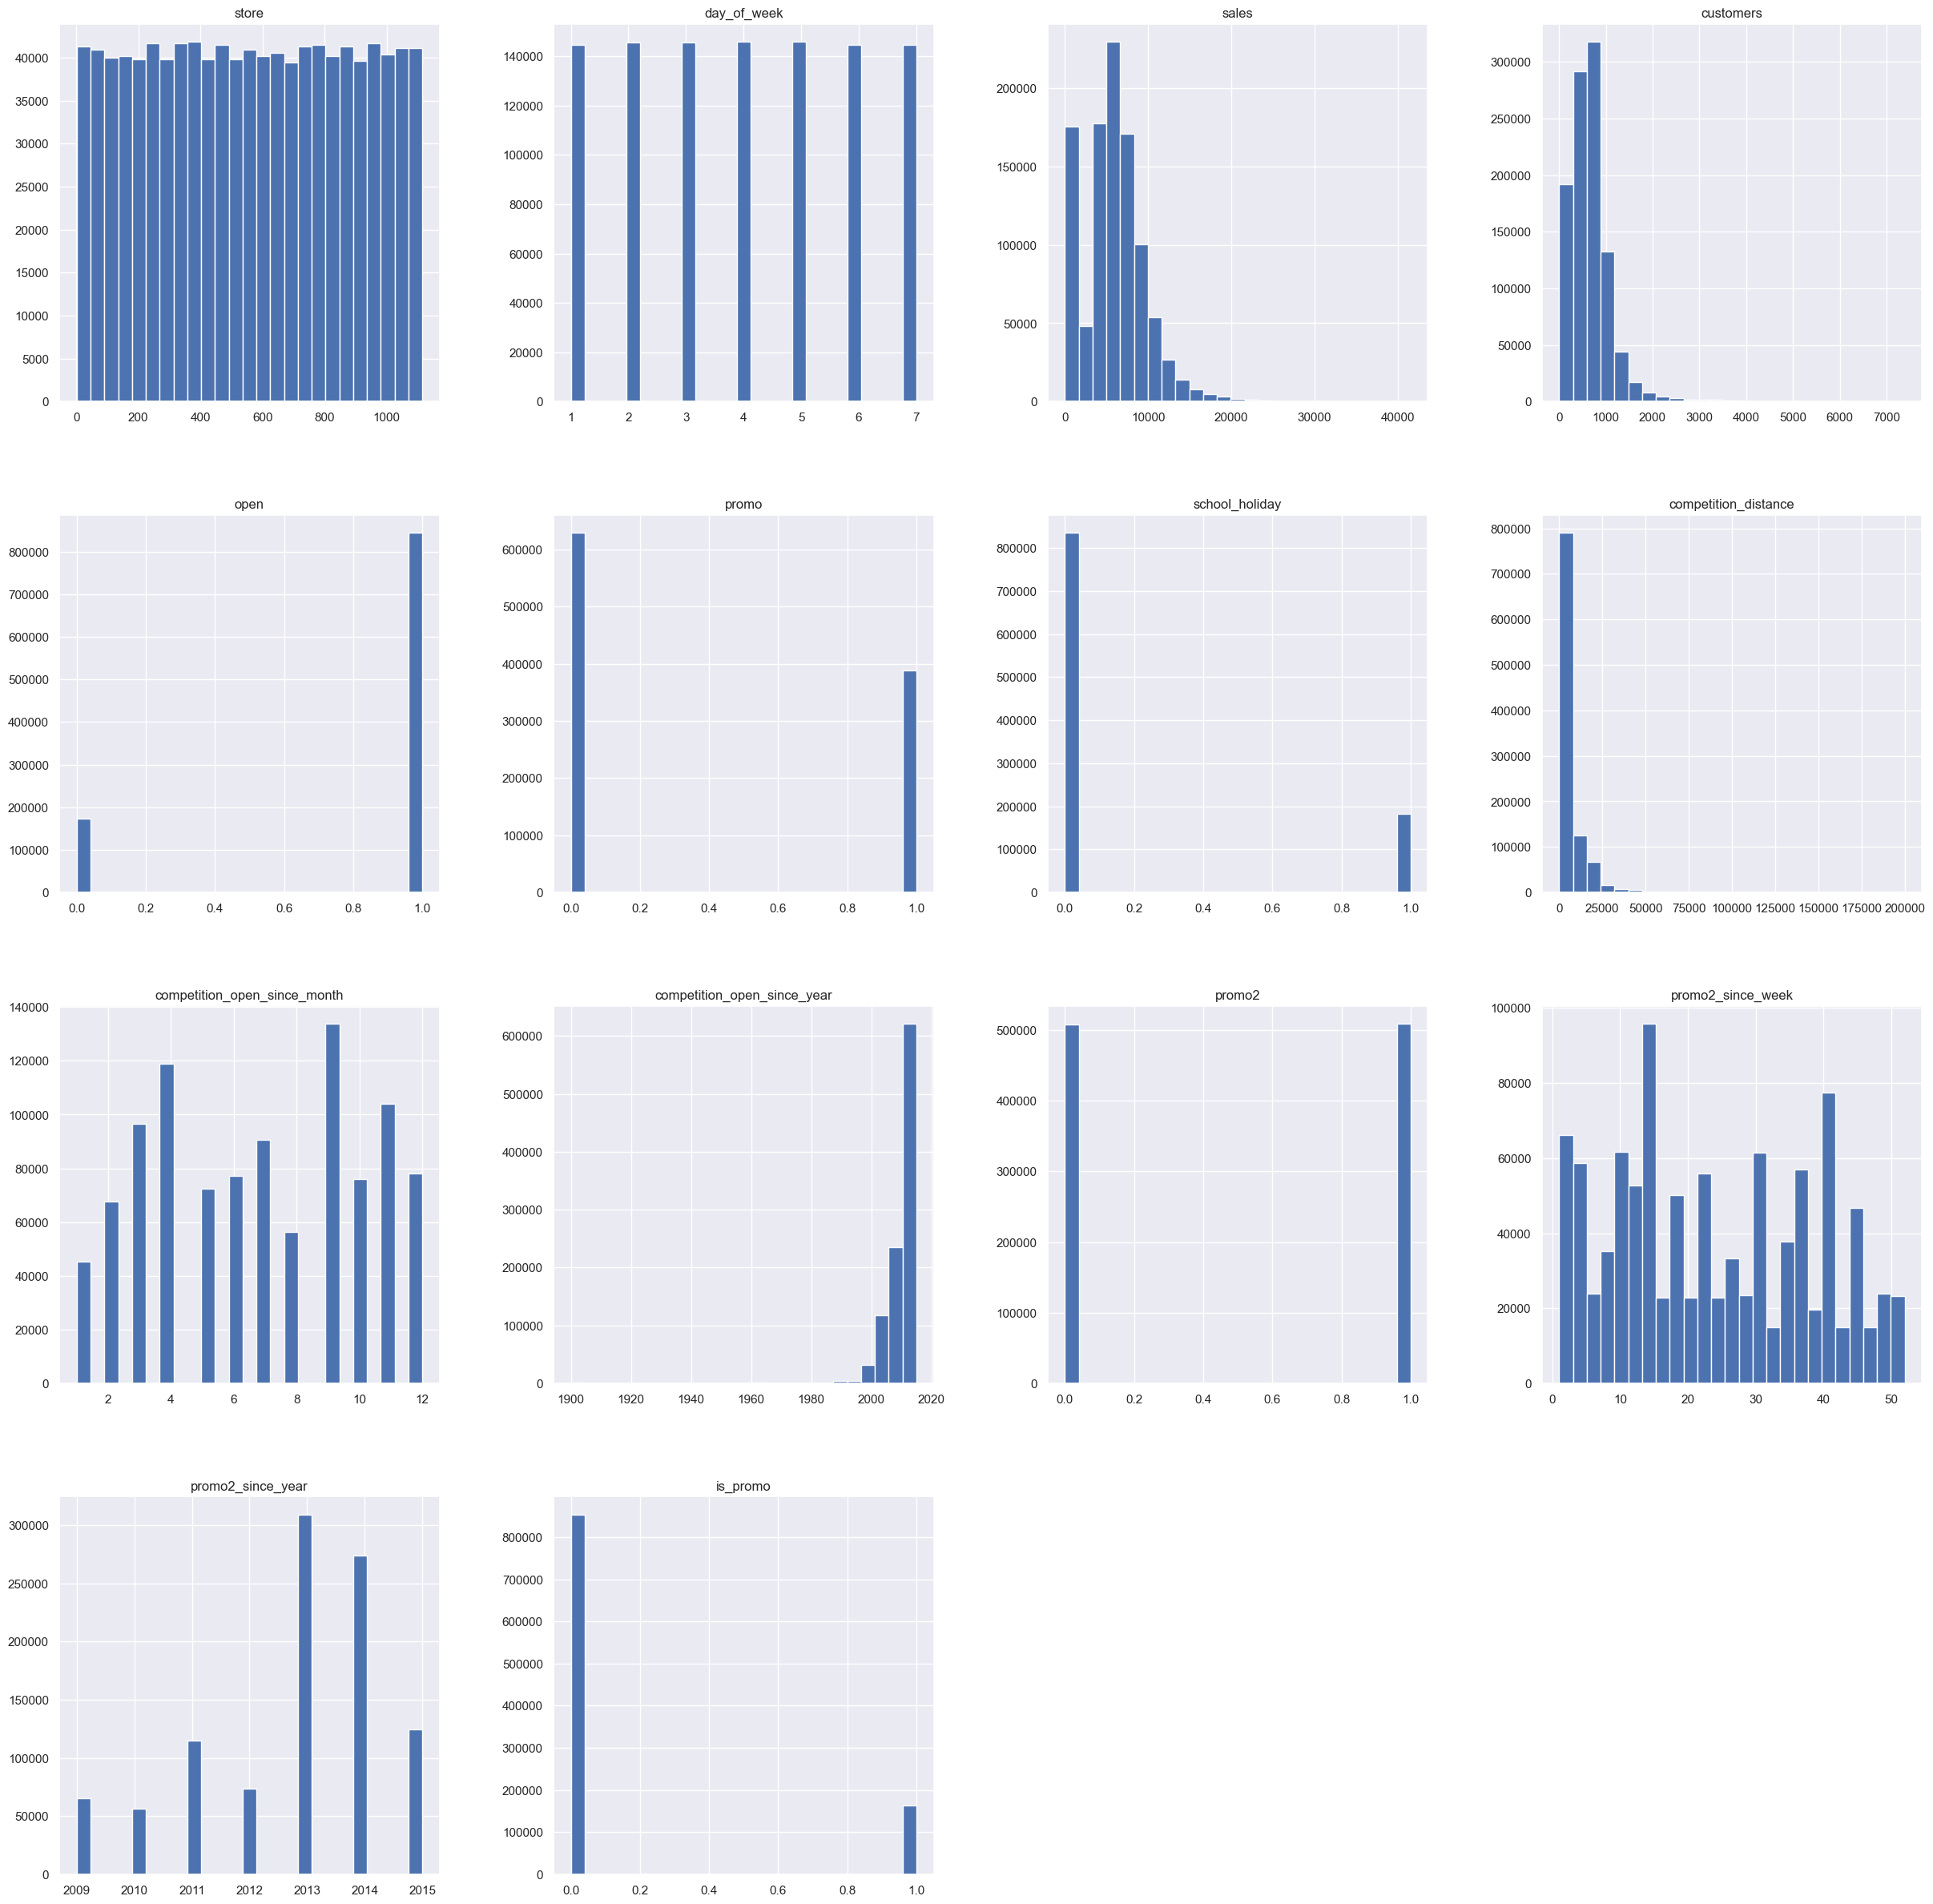

In [87]:
num_attributes.hist(bins=25,figsize=[30,30],layout =[4,4]);

Analisando os gráficos é possível perceber que:

- **is_promo** (se tem promoção (1) ou não (0)) tem mais vendas quando não tem promoção do que quando tem. 

- **promo2_since_year** (ano em que a promoção consecutiva começou) em 2013 e em 2014 teve mais promoçãos consecutivas

- **promo2_since_week** (semana em que a promoção consecutiva começou) 

- **promo2** (se a promoção é contínua e consecutiva) o número de vendas se a promoção continuou ou não é bem proximo.

- **competition_open_since_year** (ano aproximado que o competidor inaugurou) As lojas em sua maioria inauguraram depois de 2000, tendo uma concentração maior em 2014. 

- **competition_open_since_month** (mês aproximado que o competidor inaugurou) As lojas inauguraram com mais frequência em abril e em novembro. Tem um comportamento interessante.   

- **competition_distance** (distância até outro competidor) Existe uma alta concentração de competidores com uma distância pequena, ou seja existem mais competidores mais próximos das lojas do que longe. 

- **school_holiday** (indica se a loja foi afetada pelo feriado das escolas) a maioria das lojas não são afetadas pelos feriados escolares

- **promo** (indicador se tem promoção no dia) tem mais vendas quando não tem promoção do que quando tem. 

- **open** (indicador se a loja ta aberta) não tem um comportamento relavante porque obviamente a loja vai vender mais se estiver aberta. 

- **customers** (n° de clientes por dia) nos primeiros dias tem mais clientes (???)

- as vendas (**sales**) seguem uma distribuição próxima da normal, tem alta kutosis e Skewness positiva (deslocamento a esquerda);

- **day_of_week** não tem um comportamento relevante, ou seja, o dia da semana não impacta nas vendas. Tem baixa kurtosis, tem a mesma chance de tudo acontencer;

- **store** (ID da loja) não tem um comportamento relavante.

### 4.1.3 Categorical Variable

In [88]:
cat_attributes.head().T

,0,1,2,3,4
state_holiday,0,0,0,0,0
store_type,c,a,a,c,a
assortment,a,a,a,c,a
promo_interval,0,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",0,0
month_map,Jul,Jul,Jul,Jul,Jul


In [89]:
#state_holiday
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\laism\AppData\Local\Temp\ipykernel_22848\1028014474.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True)
C:\Users\laism\AppData\Local\Temp\ipykernel_22848\1028014474.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True)
C:\Users\laism\AppData\Local\Temp\ipykernel_22848\1028014474.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade=True)


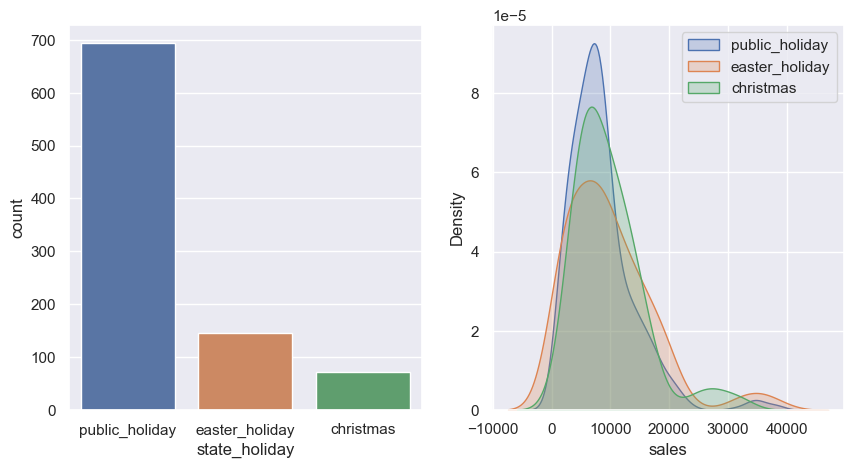

In [90]:
#state_holiday
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])


plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade=True)
plt.legend(labels=["public_holiday","easter_holiday","christmas"])

In [91]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

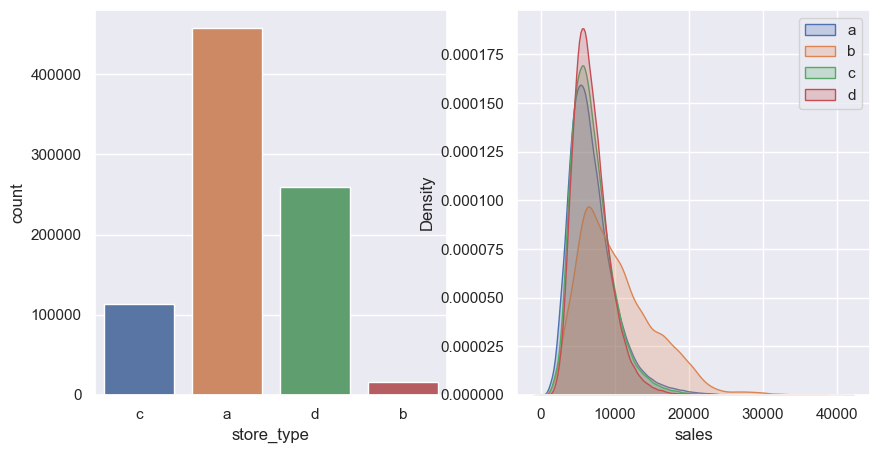

In [112]:
#store_type
plt.subplot(1,2,1)
sns.countplot(x='store_type', data=df4)

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], fill=True)
plt.legend(labels=["a","b","c","d"])

In [101]:
#assortment
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

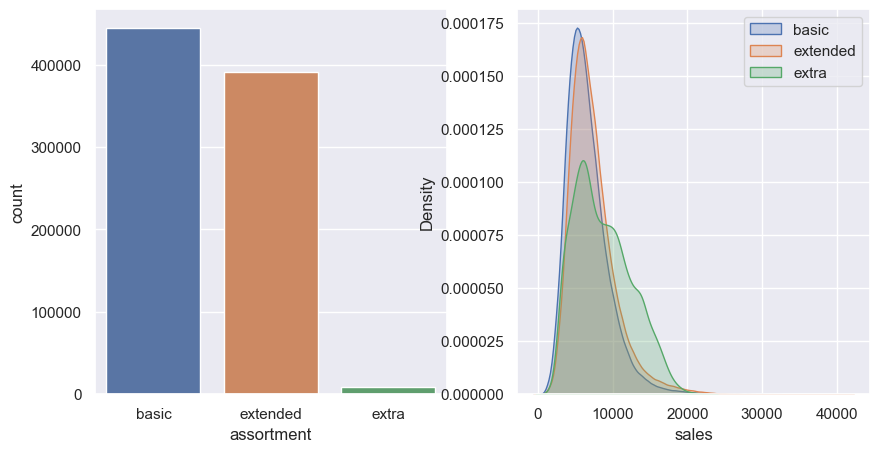

In [113]:
#assortment
plt.subplot(1,2,1)
sns.countplot(x='assortment', data=df4)

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], fill=True)
plt.legend(labels=["basic","extended","extra"])

## 4.1 Análise Bivariada

### **H1**. Lojas com maior sortimentos deveriam vender mais.

**Falso** - Lojas com MAIOR SORTIMENTO vendem MENOS.

A variável assortment vai ser importante para o modelo porque tem um comportamento interessante. Apesar de basic e extended serem bem parecidos, o extra é bem diferente

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


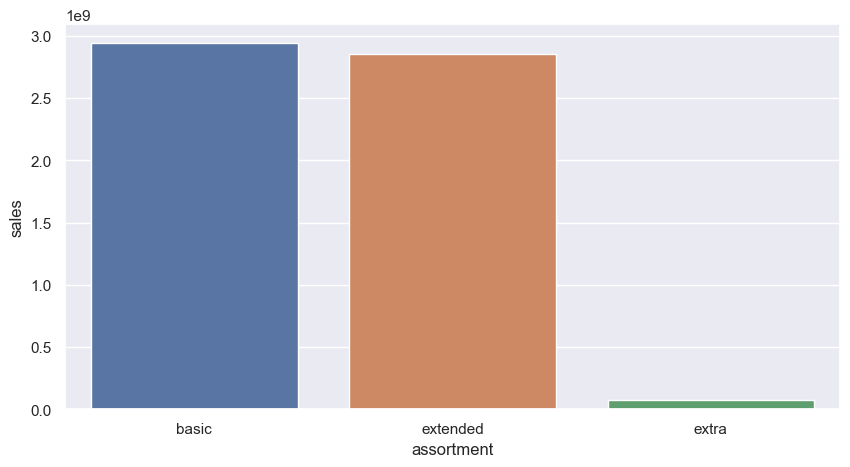

In [105]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data=aux1)

aux1

<Axes: xlabel='year_week'>

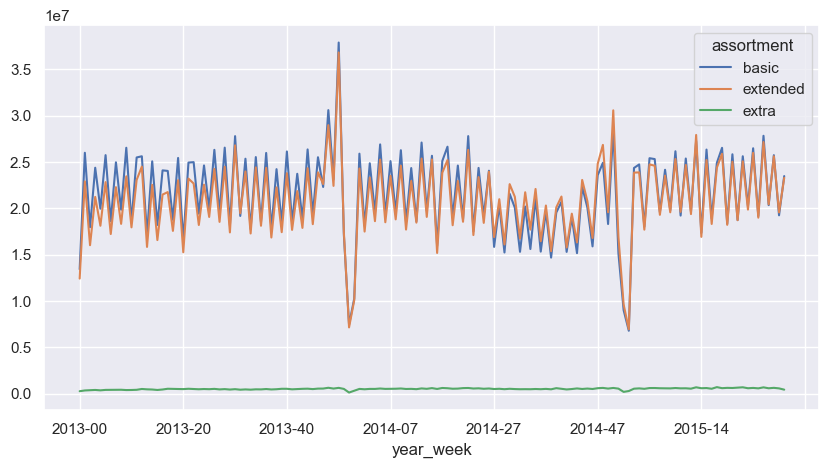

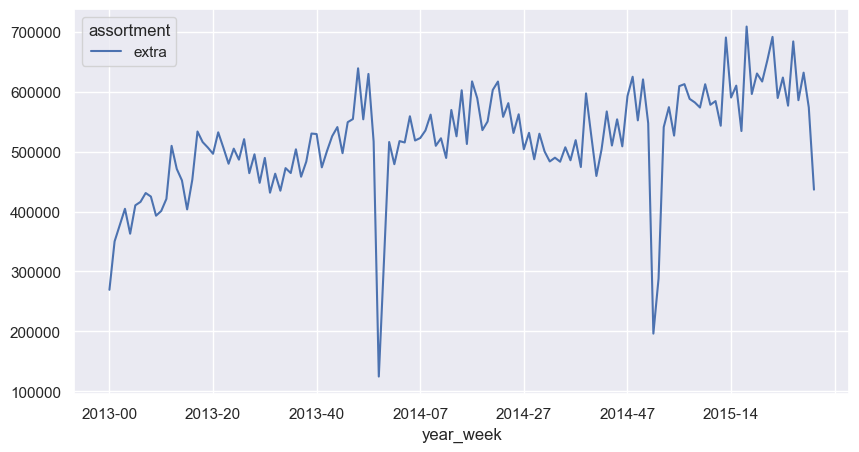

In [108]:
#avaliando a relação do assortment e as vendas no decorrer do tempo
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()

#criando uma tabela e posterior gráfico de valores agrupados que agrega os itens individuais de uma tabela mais extensa em uma ou mais categorias discretas.
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

#avaliando o assortment extra mais de perto
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**Falso** - Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

A variável competition_distance vai ser importante para o modelo porque tem uma correlação com sales não tão proxima de zero. 

<Axes: xlabel='competition_distance_binned', ylabel='sales'>

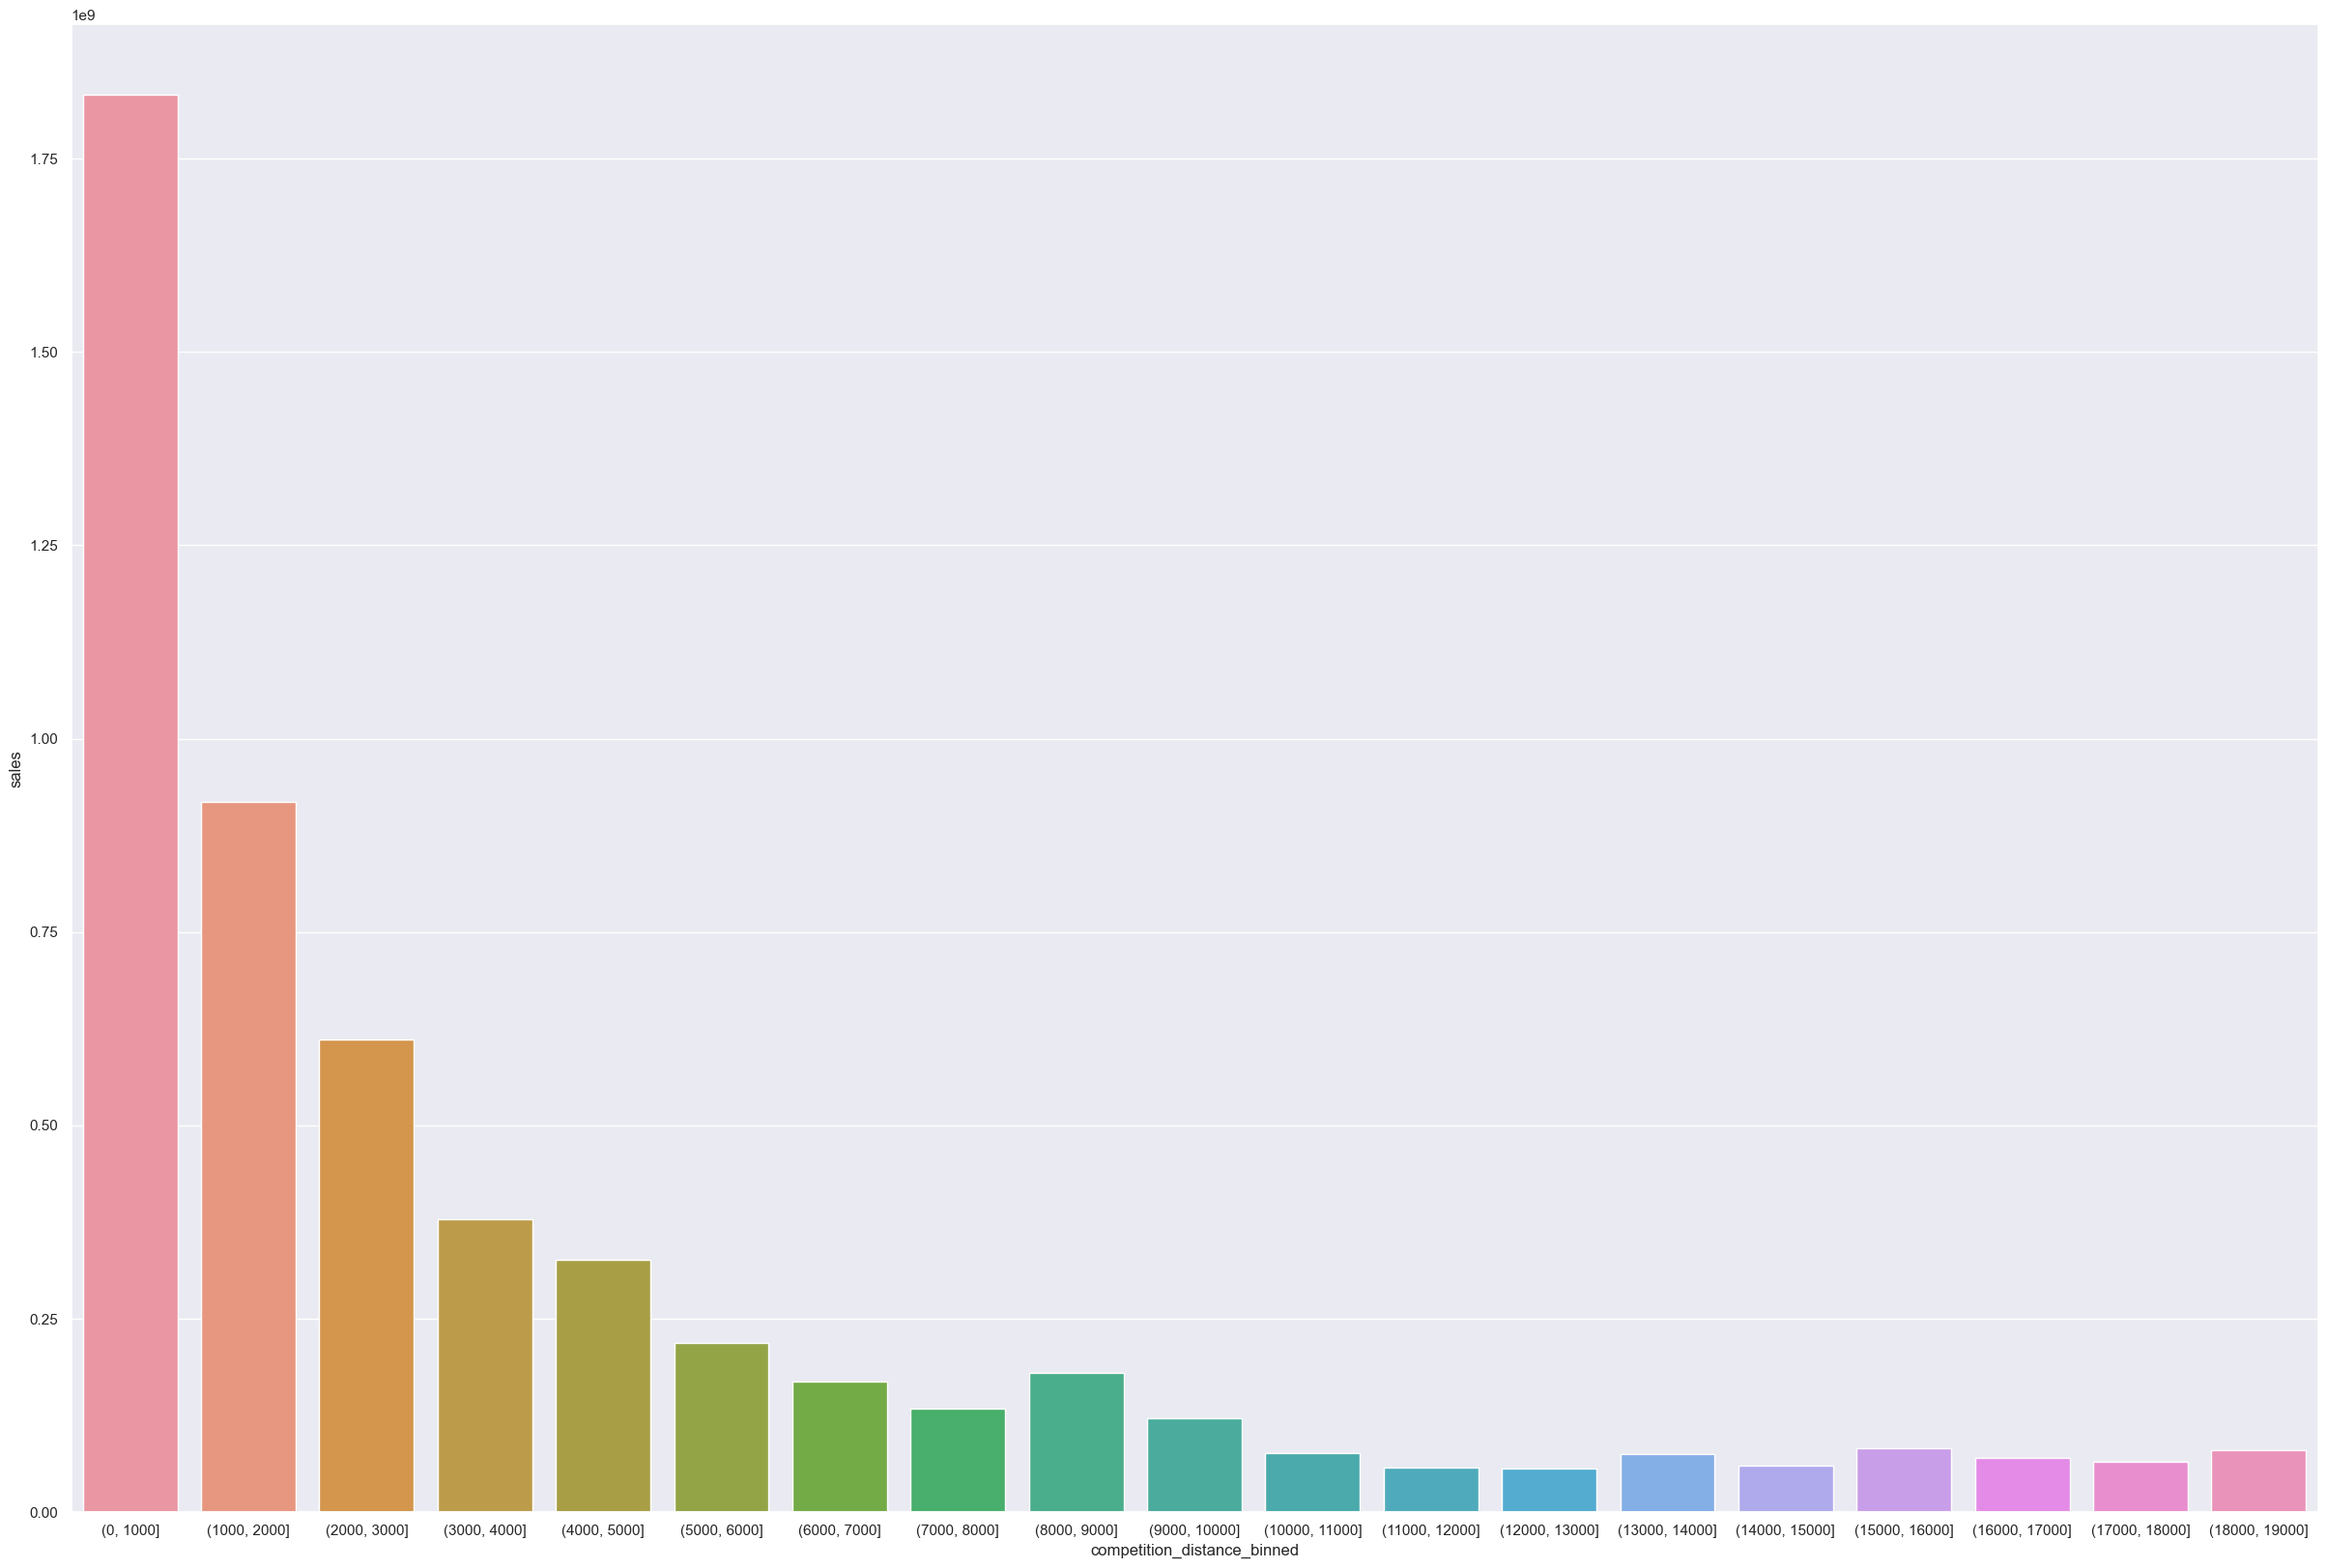

In [114]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#como tem mts distancias diferentes, vou agrupar as distancias de 1000 em 1000
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)

#agrupando
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(30,20))
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)
#plt.xticks(rotation=90);

In [115]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
317,4330.0,4716888,"(4000, 5000]"
256,3210.0,11570790,"(3000, 4000]"
435,8040.0,8984969,"(8000, 9000]"
308,4140.0,14002538,"(4000, 5000]"


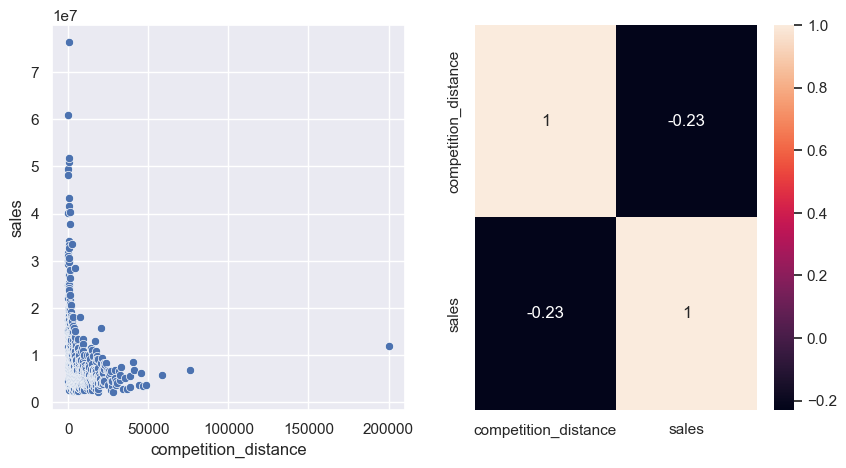

In [116]:
#para entender a distribuição dos valores
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

#gráfico com a correlação entre competition distance e sales
plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#quanto mais proximo de 0 mais fraca é a correlação 
#quanto mais proximo de 1 ou -1 mais forte é a correlação

#uma correlação de -0,2 significa que quanto mais distante o competidor está maior a venda

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**Falso** - Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS. 

A variável competion_time_month vai ser importante para o modelo porque tem uma correlação com sales não tão proxima de zero. 

In [117]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_wear', 'year_week', 'competion_since',
       'competion_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

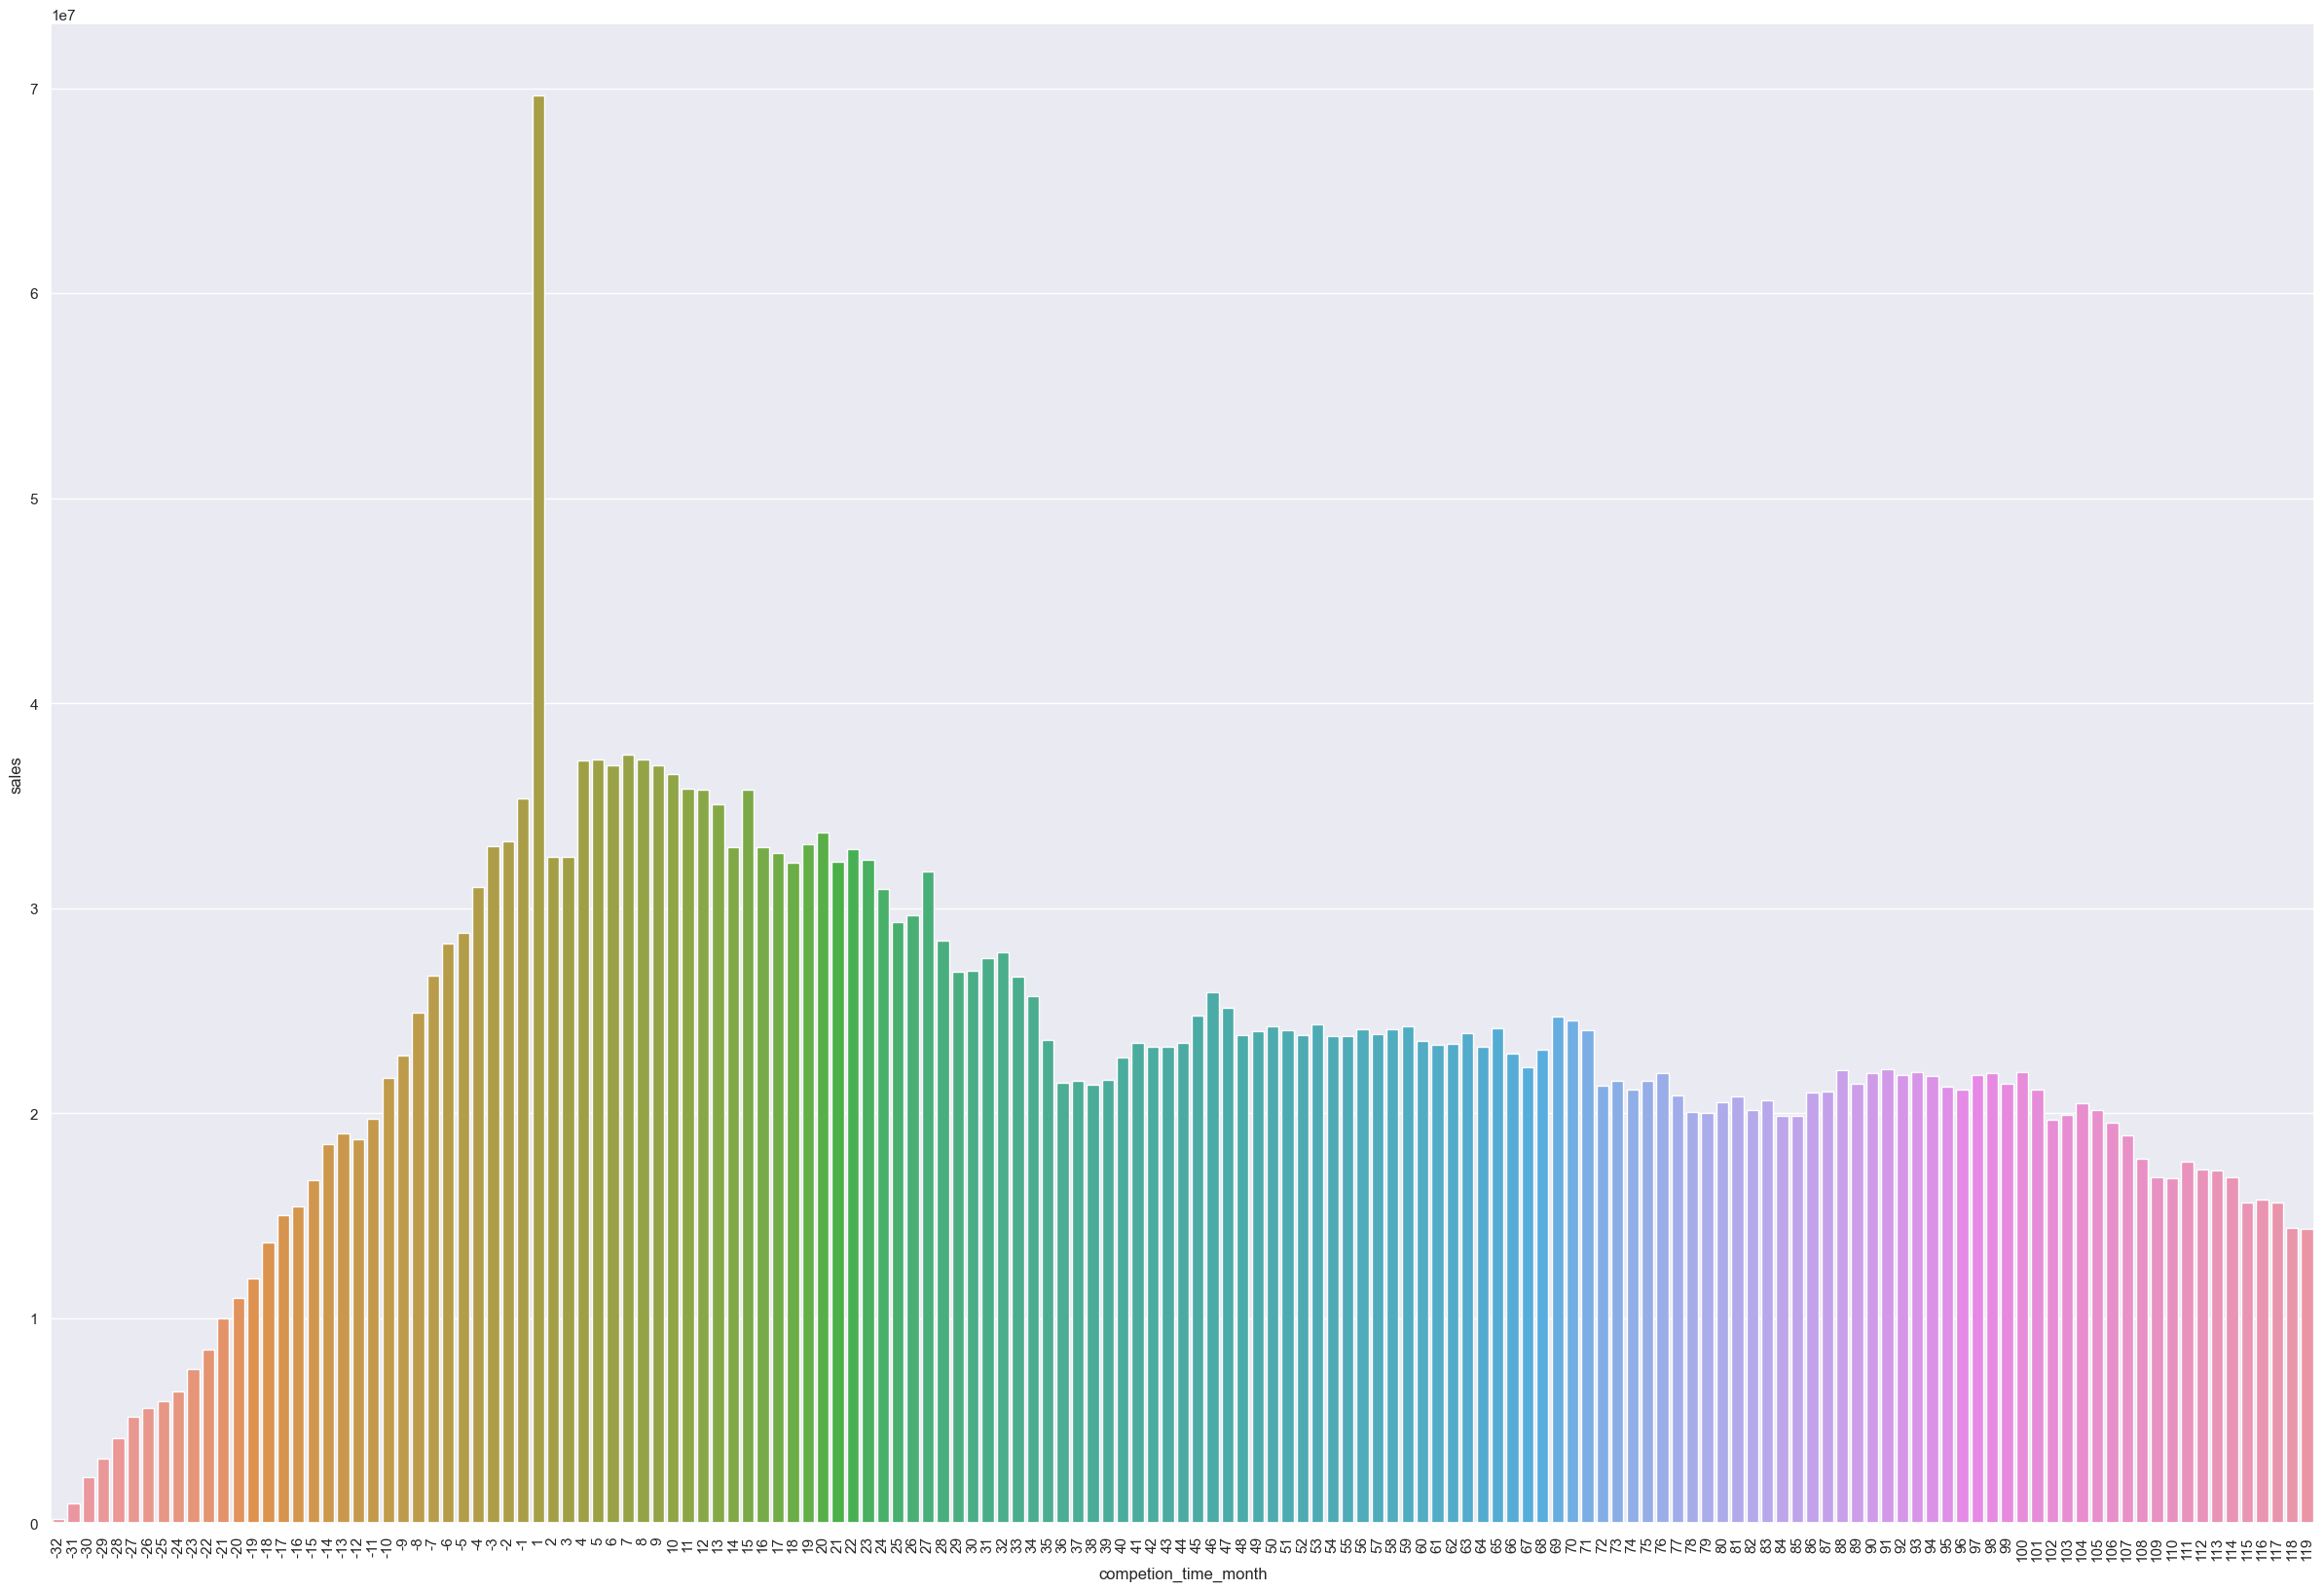

In [118]:
aux1 = df4[['competion_time_month','sales']].groupby('competion_time_month').sum().reset_index()

#a granularidade tá muito grande, então vou fazer um filtro para pegar só os 120 primeiros meses e que começou no msm mes da venda
plt.figure(figsize=(30,20))
aux2 = aux1[(aux1['competion_time_month'] < 120 ) & (aux1['competion_time_month'] != 0)]
sns.barplot(x='competion_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

#quanto mais se aproxima de zero, ou seja, quanto menor o tempo que o competidor inaugurou maior é a venda

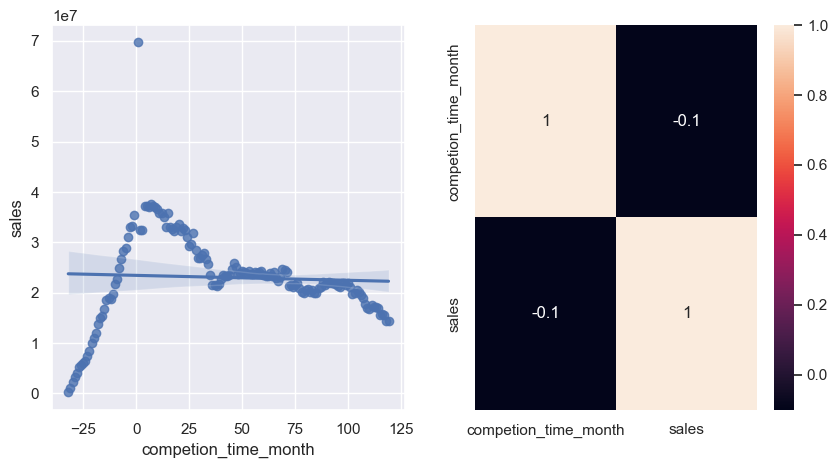

In [119]:
plt.subplot(1,2,1)
aux2 = aux1[(aux1['competion_time_month'] < 120 ) & (aux1['competion_time_month'] != 0)]
sns.regplot(x='competion_time_month',y='sales',data=aux2)

#gráfico com a correlação entre competition distance e sales
plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#quanto mais proximo de 0 mais fraca é a correlação 
#quanto mais proximo de 1 ou -1 mais forte é a correlação


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falso** - As vendas são regulares até um certo período, mas depois de um tempo com a promoção ativa percebe-se que as vendas diminuem.
 

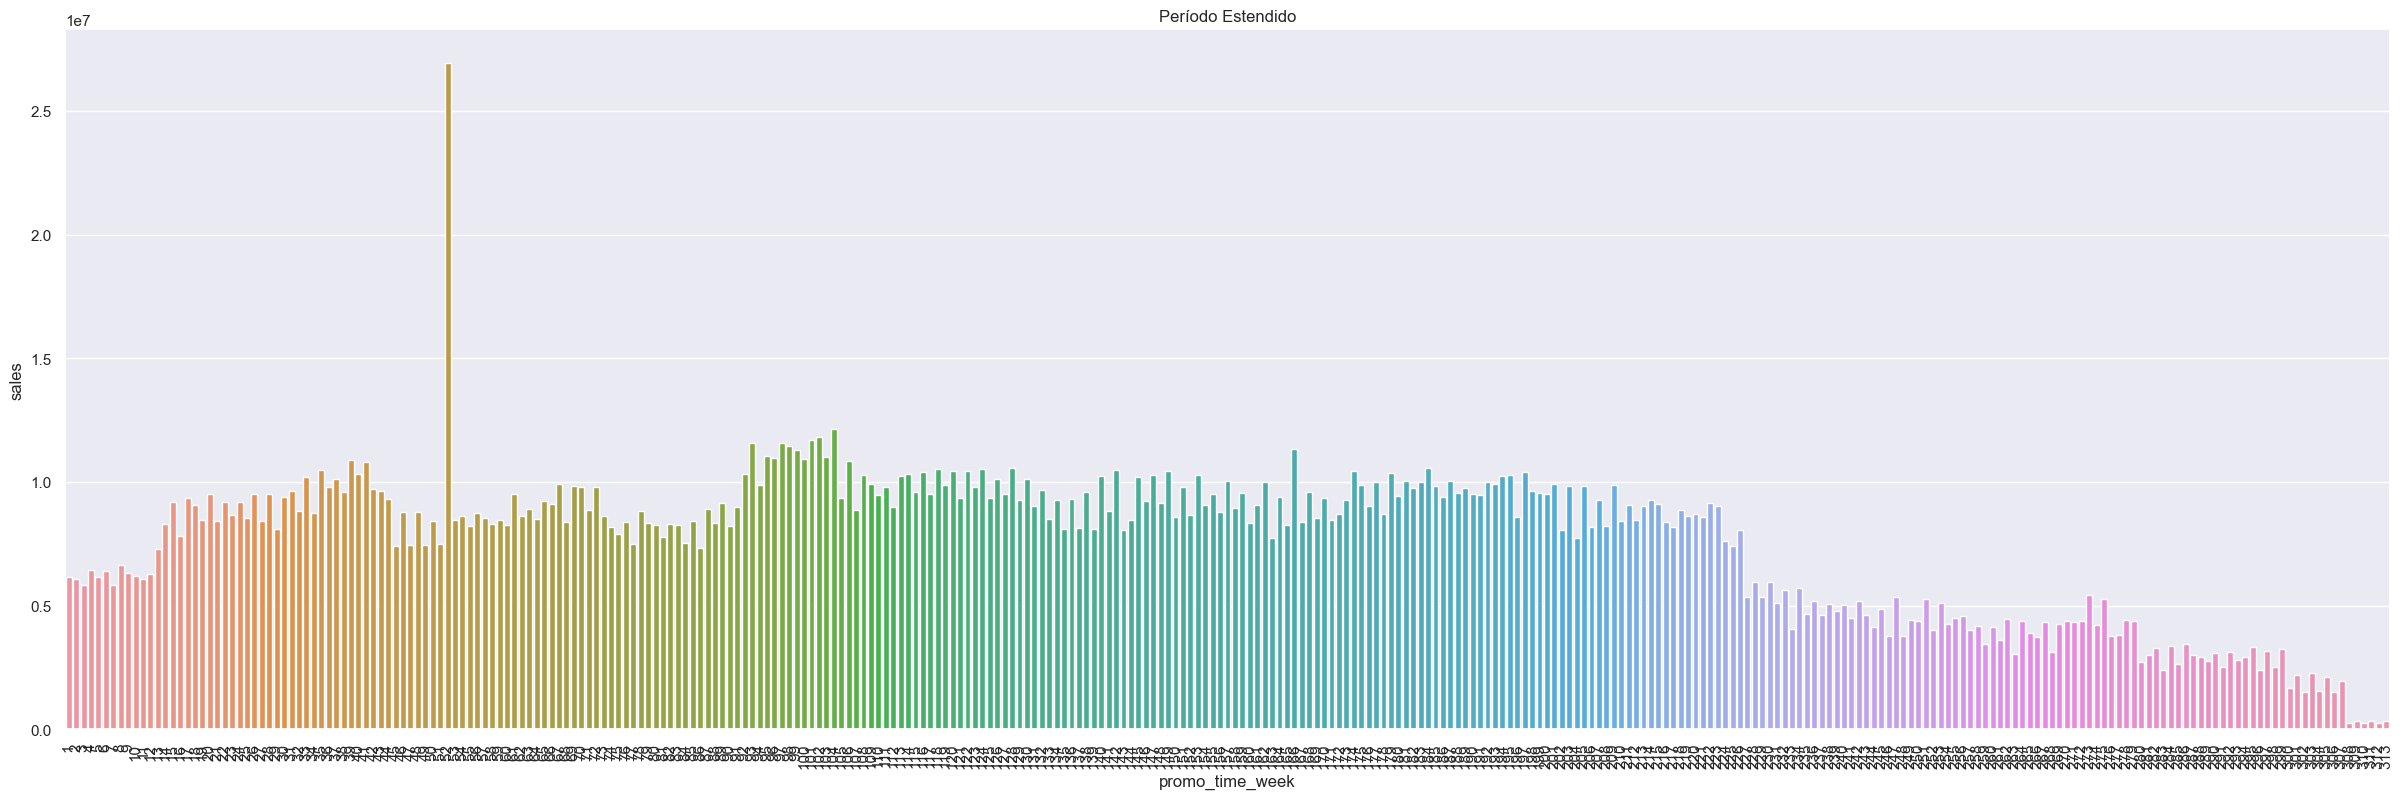

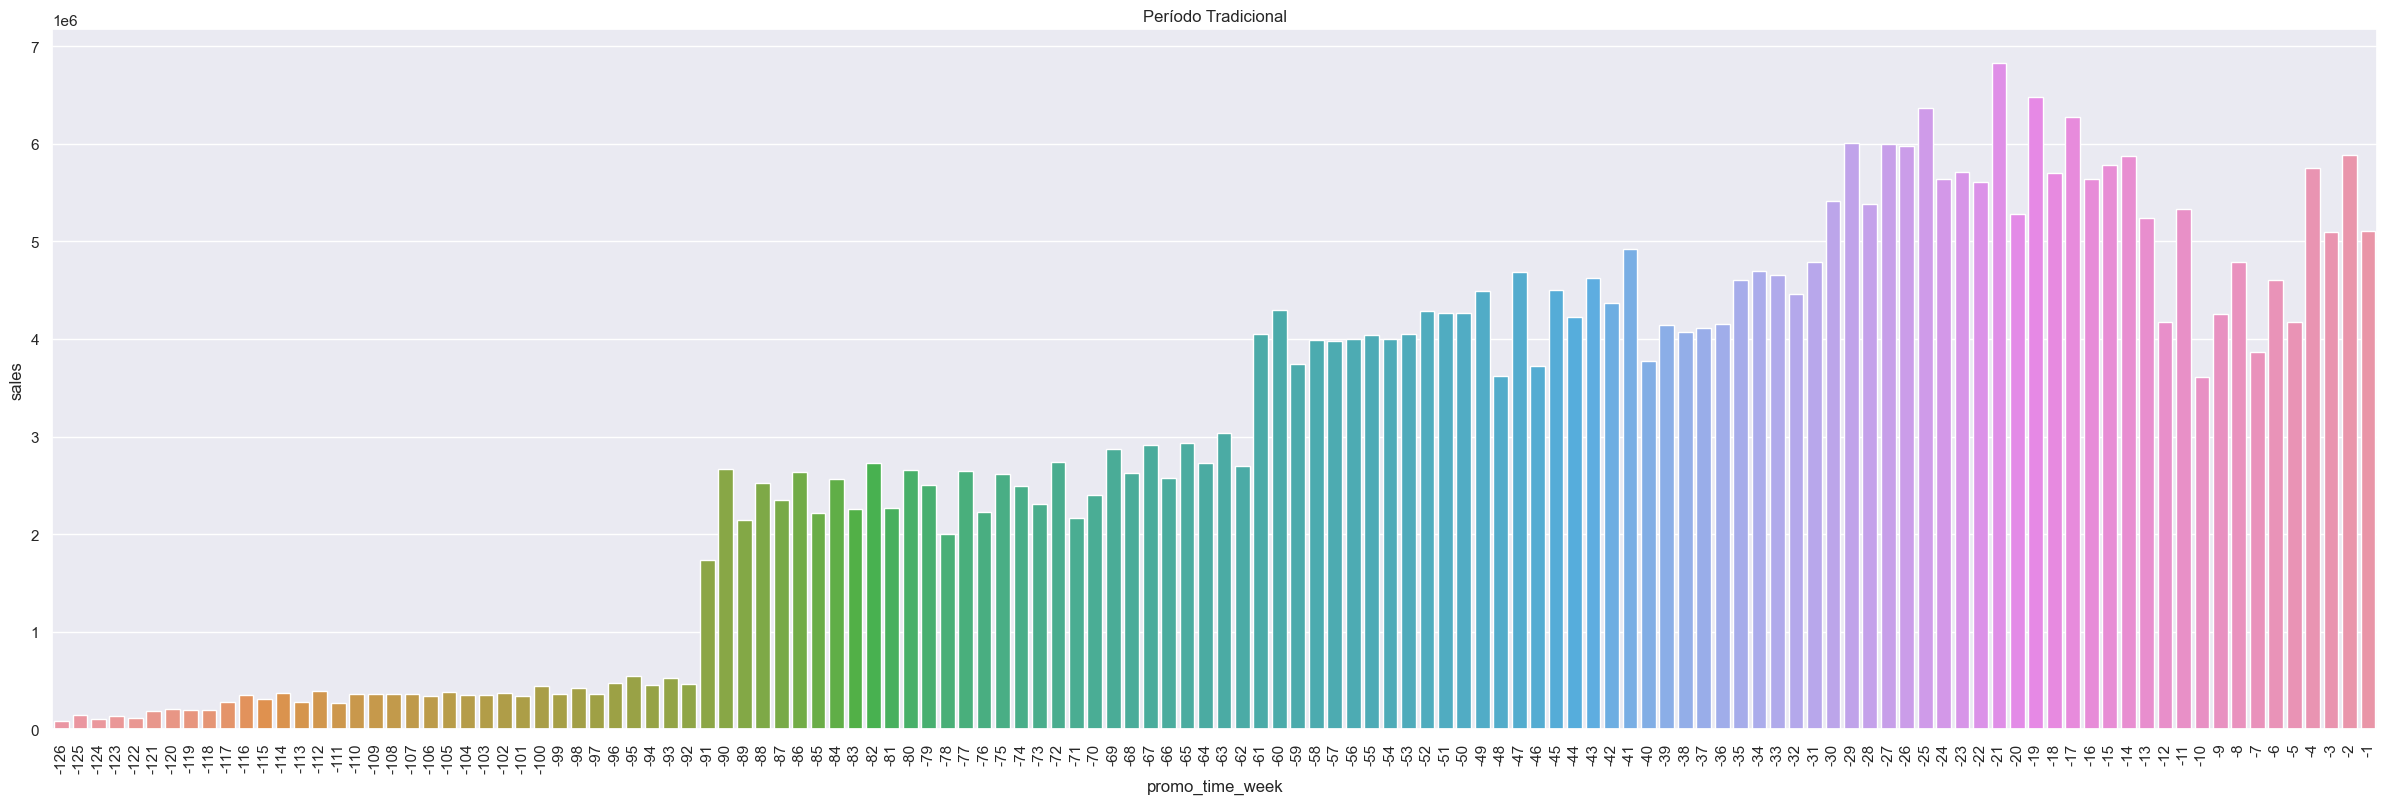

In [120]:
# a data que a promoção estendida começou é a data que a promoção tradional acabou
# a promo time week calcula a diferença entre a data da promoção estendida e a data da venda
# se for positivo significa que a venda foi feita na promoção estendida
# se for negativa significa que a venda foi feita no periodo tradicional da promoção
# vou fazer a separação do dataset para ficar melhor de visualizar
aux1= df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot( x='promo_time_week', y='sales' , data=aux1);

plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo estendido
sns.barplot( x='promo_time_week', y='sales' , data=aux2).set(title='Período Estendido');
plt.xticks(rotation=90);


plt.figure(figsize=(30,20))
plt.subplot(2,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0] #periodo tradicional
sns.barplot( x='promo_time_week', y='sales' , data=aux3).set(title='Período Tradicional');
plt.xticks(rotation=90);


<Axes: >

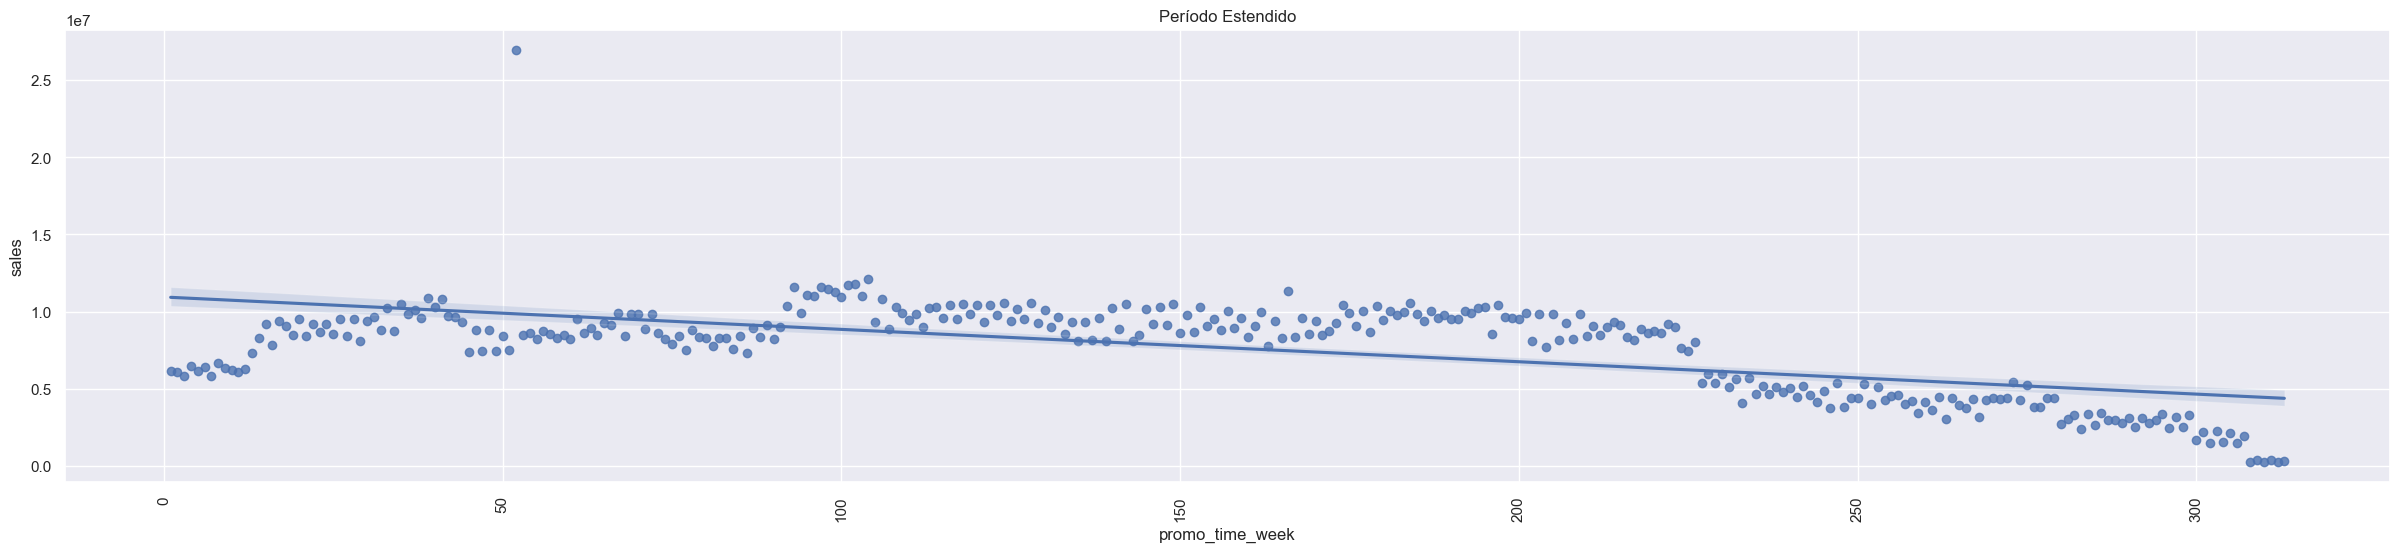

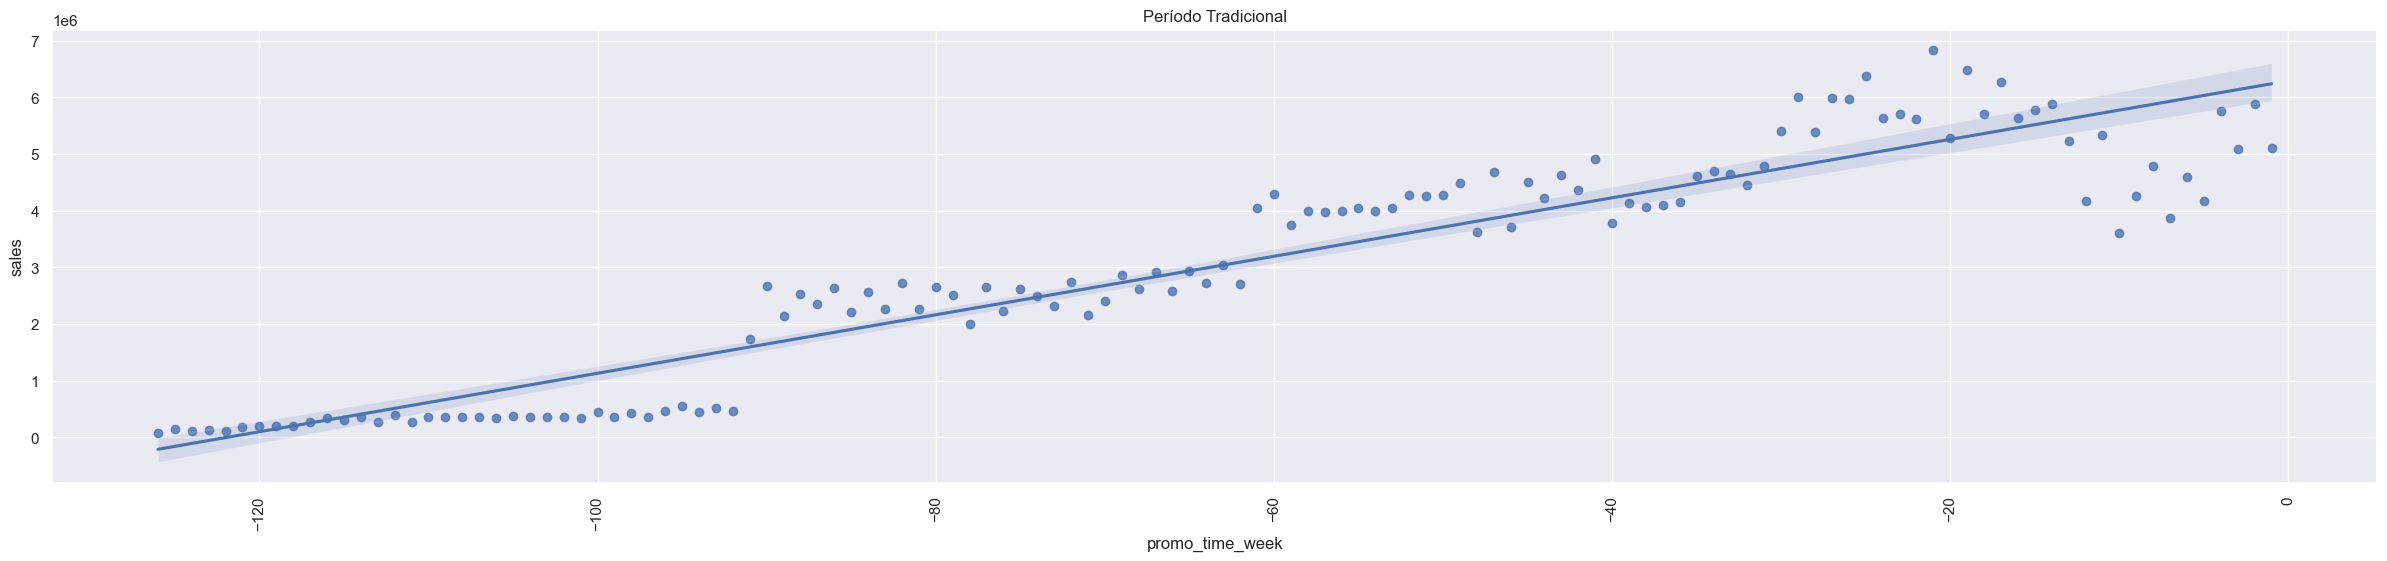

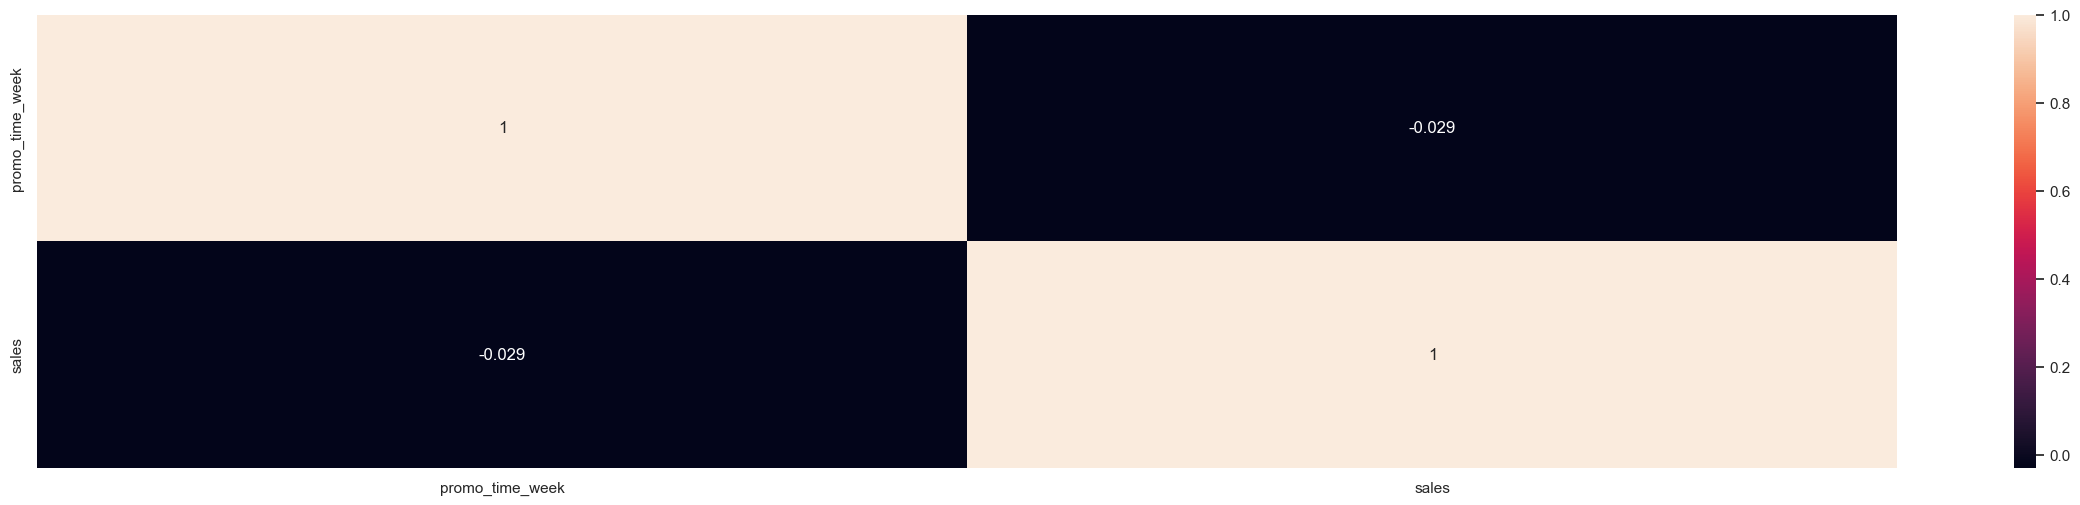

In [121]:
#tendencia
plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
sns.regplot( x='promo_time_week', y='sales' , data=aux2).set(title='Período Estendido');
plt.xticks(rotation=90);

plt.figure(figsize=(30,20))
plt.subplot(3,1,2)
sns.regplot( x='promo_time_week', y='sales' , data=aux3).set(title='Período Tradicional');
plt.xticks(rotation=90);

#força de correlação
plt.figure(figsize=(30,20))
plt.subplot(3,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**Falso** - Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS. 

A variável provavelmente não vai ser importante para o modelo porque ter ou não promoção consecutiva deixa o comportamento muito parecido

In [122]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


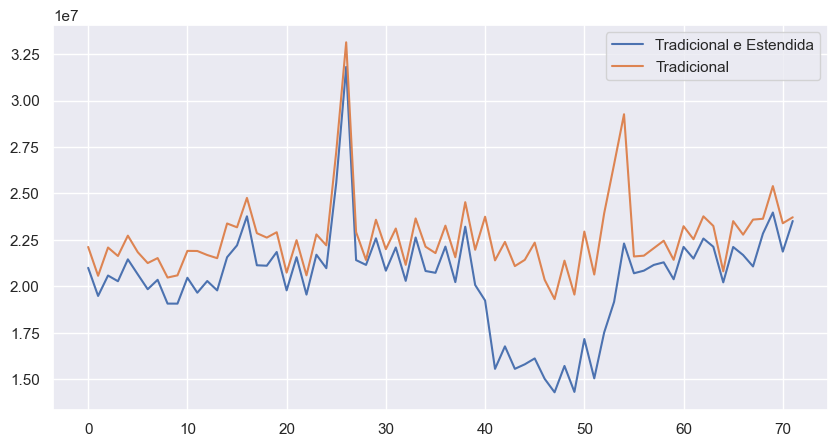

In [123]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Estendida','Tradicional'])

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**Falso** - Lojas ABERTAS DURANTE O NATAL vendem MENOS. 


In [124]:
df4[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


<Axes: xlabel='state_holiday', ylabel='sales'>

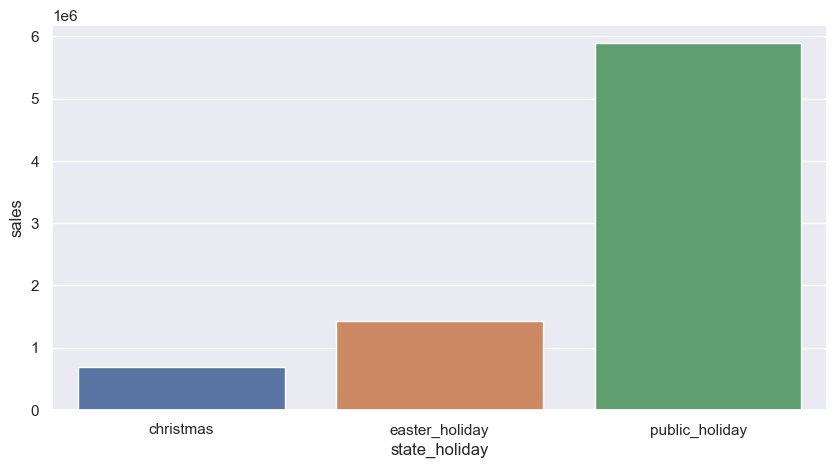

In [125]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data=aux1)

In [126]:
#avaliando se em outros anos teve mais venda
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
aux2

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


<Axes: xlabel='year', ylabel='sales'>

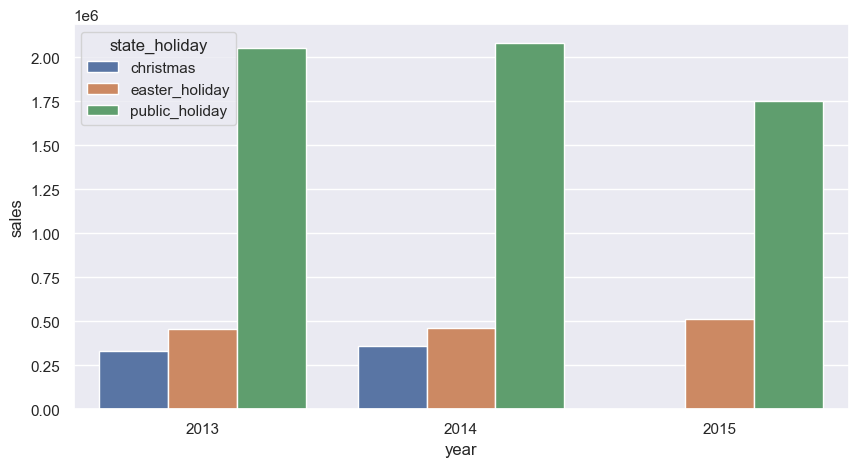

In [127]:
sns.barplot( x ='year',y ='sales', hue='state_holiday', data= aux2)

### **H9.** Lojas deveriam vender mais ao longo dos anos.

**Falso** - Lojas vendem MENOS AO LONGO DOS ANOS. 

Pelos gráficos consegue notar a dependência decrescente entre os anos e as vendas. 

Possui uma correlação bem grande negativamente de -0,92, ou seja, assim que os anos vão avançando as vendas vão caindo. Mas é importante notar que os dados não contem o ano de 2015 completo, então realmente vai ter menos vendas. 

In [128]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

<Axes: >

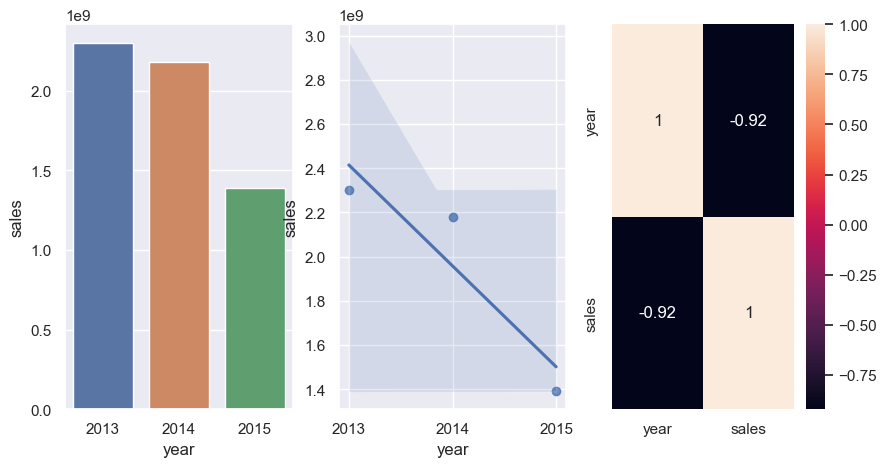

In [129]:
plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year', y= 'sales', data =  aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

### **10.** Lojas deveriam vender mais no segundo semestre do ano.

**Verdadeiro** - Lojas vendem MAIS no segundo semestre do ano. 

As vendas não tem muita variação no decorrer dos meses, mas em dezembro as vendas são bem maiores. A correlação entre as variáveis não é tão alta. 

<Axes: >

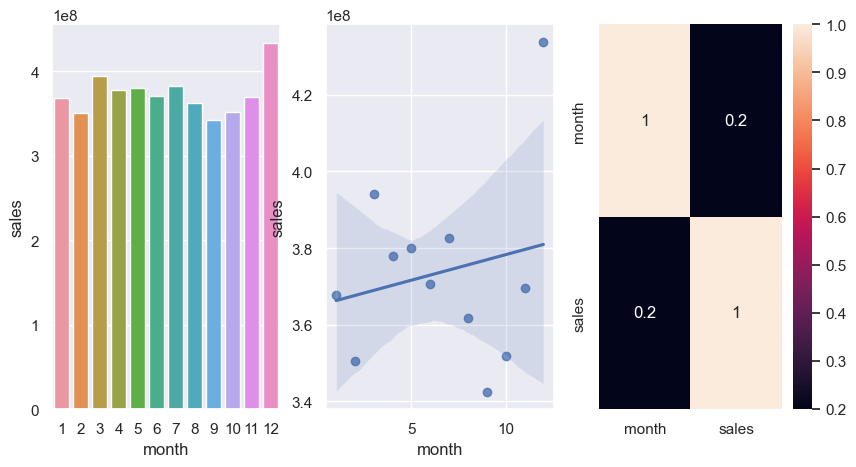

In [130]:
#tirando os dados de 2015 porque o ano não está completo
aux = df4[df4['year'] != 2015]

aux1 = aux[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y= 'sales', data =  aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

### **11**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**Verdadeiro** - Lojas vendem MAIS depois do dia 10 de cada mês.

É importante notar que a separação after/before_10_days não é homogênia porque tem mais dias depois do dia 10 do que antes. Mas notou-se que as vendas depois do dia 10 são realmente maiores.

<Axes: xlabel='before_after', ylabel='sales'>

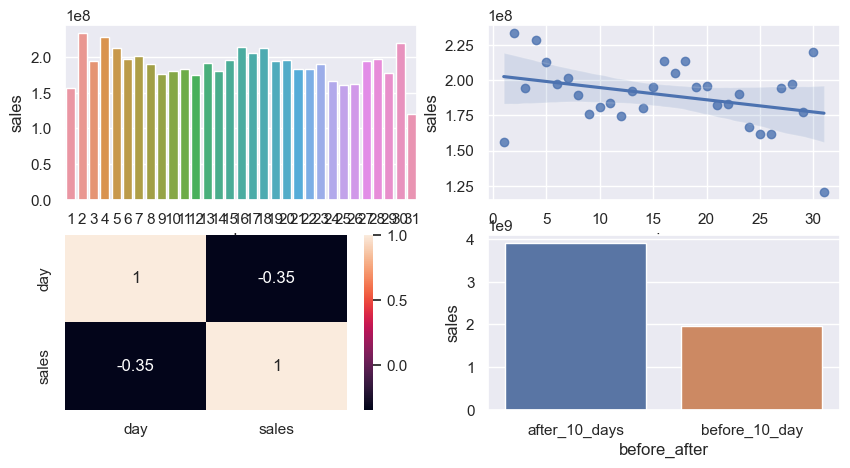

In [131]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y= 'sales', data =  aux1)

plt.subplot(2,2,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

#criando um coluna que avalia se o dia é anterior ao dia 10
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y = 'sales', data= aux2)

### **H12.** Lojas deveriam vender menos aos finais de semana.

**Verdadeiro** - Lojas vendem MENOS aos finais de semana.

<Axes: >

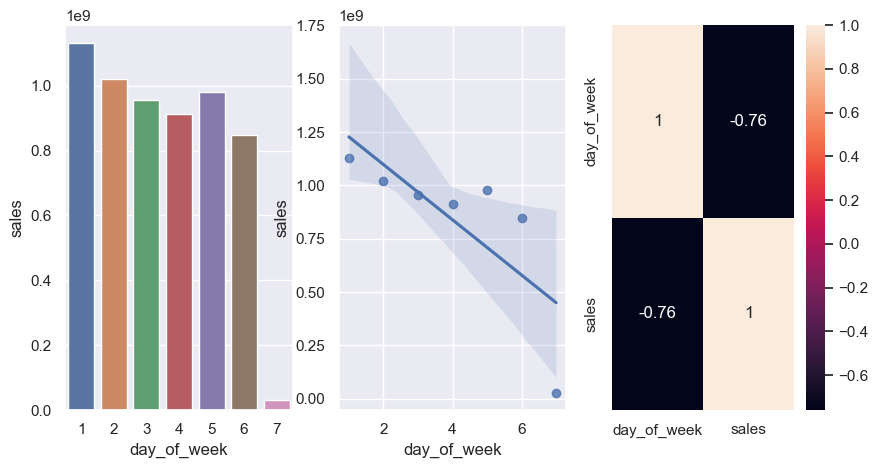

In [132]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y= 'sales', data =  aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

#dia 1 é segunda e 7 é domingo

### **H13.** Lojas deveriam vender menos durante os feriados escolares

**VERDADEIRO** - Lojas vendem MENOS durante os feriados, exceto nos meses de Julho e Agosto. 

Em Julho por ser férias as vendas quase se equiparam. E em Agosto as vendas são maiores nos períodos de feriado escolar. 

<Axes: xlabel='month', ylabel='sales'>

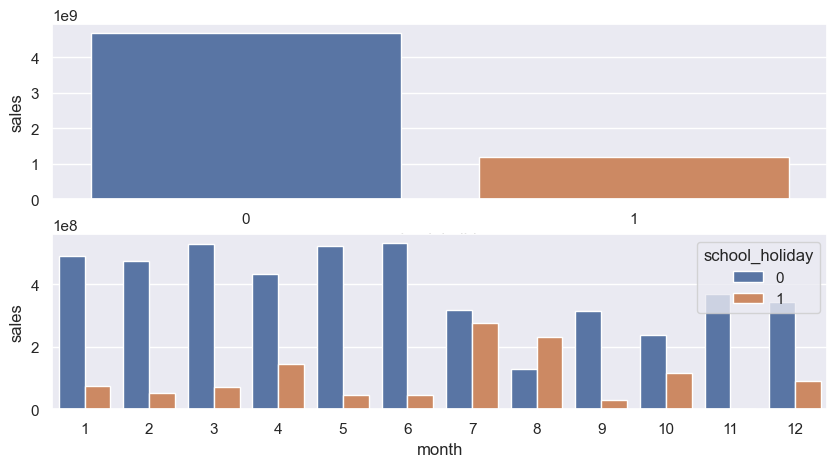

In [133]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

#avaliando por mês
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue='school_holiday', data=aux2)

#school holiday igual a zero significa que é aula normal, igual a 1 é feriado escolar


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

<Axes: >

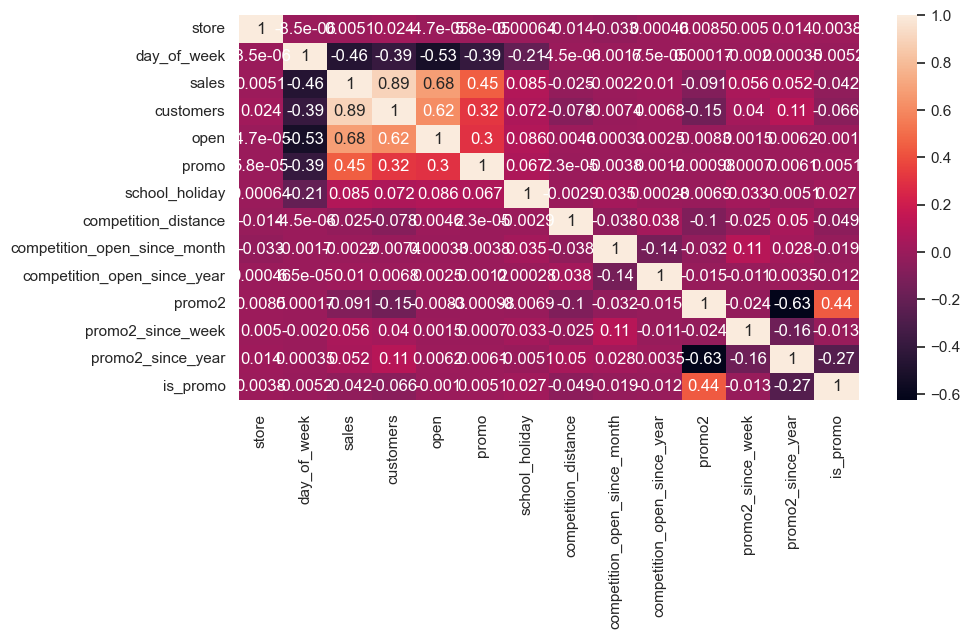

In [134]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#quanto mais perto da cor preta maior é a correlação negativa 
#e quanto mais perto do branco maior é a correlação positiva 

### 4.3.2 Categorical Attributes

In [135]:
a = df4.select_dtypes(include='object')
a

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


Para fazer a correlação entre os atributos categoricos vou usar o **método cramer v**. Essa correlação vai de 0 a 1, não existe  correlação negativa, quanto mais perto do 0 menor a correlação. 

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V



In [147]:
#Image(r"C:\Users\laais\CDS_DS_em_produção\cramer v.png")

In [137]:
#tabela de contingencia/confusing matrix (cm)
#pega duas variaveis categoricas q eu queria fazer a correlação
cm = pd.crosstab( a['state_holiday'], a['store_type']).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [138]:
chi2 = ss.chi2_contingency(cm)[0]
chi2

n = cm.sum()

r, k = cm.shape

In [139]:
v = np.sqrt( (chi2/n) / (min(k-1, r-1)))
v

0.07106457093267678

In [140]:
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    return np.sqrt( (chi2/n) / (min(k-1, r-1)))

In [141]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106457093267678

In [148]:
# o método de cramer v pode subestimar o valor, então é necessario fazer uma correção na fórmula
#Image(r"C:\Users\laais\CDS_DS_em_produção\cramer v2.png")

In [143]:
#função corrigida
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [144]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

In [145]:
#somente dados categoricos
a = df4.select_dtypes(include='object')

#calculando cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#dataset final
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<Axes: >

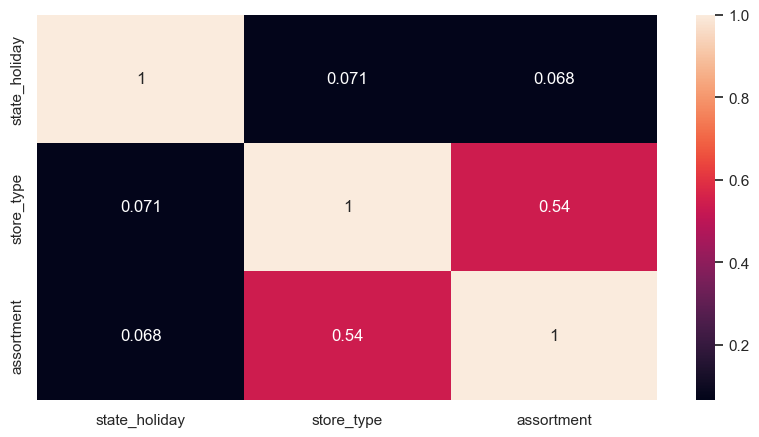

In [146]:
sns.heatmap( d, annot=True )